In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
from branca.element import Figure
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from shapely.geometry import shape
from rasterstats import zonal_stats
import textwrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import shapely.geometry


In [11]:
# Paths to vegetation data
veg_path = "jotrgeodata.gpkg"
veg_layer = "JOTR_VegPolys"


In [25]:
# Load vegetation data
veg = gpd.read_file(veg_path, layer=veg_layer)

# check coordinates reference system 
print(veg.crs)


EPSG:26911


For the purpose of this analysis, we reprojected the fire severity raster into NAD83 / UTM zone 11N to match the vegetation map, which may introduce some imprecision of sentinel 2 cells


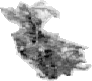

In [95]:


# Create a figure with controlled width
fig = Figure(width="800px", height="500px")

# Create folium map
m = folium.Map(
    location=center,
    zoom_start=12,
    tiles="OpenStreetMap"
)

# Add map to the figure
fig.add_child(m)

# Add overlay
folium.raster_layers.ImageOverlay(
    name="Refined RBR",
    image="rbr_overlay.png",
    bounds=img_bounds,
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1
).add_to(m)

folium.LayerControl().add_to(m)

# Show
fig


In [16]:
#Reproject raster into UTM zone 11N to match veg data


# Input and output paths
raw_raster_path = "refined_rbr.tif"
raster_path = "refined_rbr_26911.tif"

# Define target CRS directly (EPSG:26911 = NAD83 / UTM Zone 11N)
target_crs = CRS.from_epsg(26911)

with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    kwargs = src.meta.copy()
    kwargs.update({
        "crs": target_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    with rasterio.open(dst_path, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )


In [18]:
#check the reprojected raster
with rasterio.open(raster_path) as src:
    print("Reprojected raster CRS:", src.crs)

Reprojected raster CRS: EPSG:26911
Reprojected raster bounds: BoundingBox(left=561417.5418511924, bottom=3768810.7052057004, right=562667.0048846161, top=3770443.3369027073)
Reprojected raster shape: (98, 75)


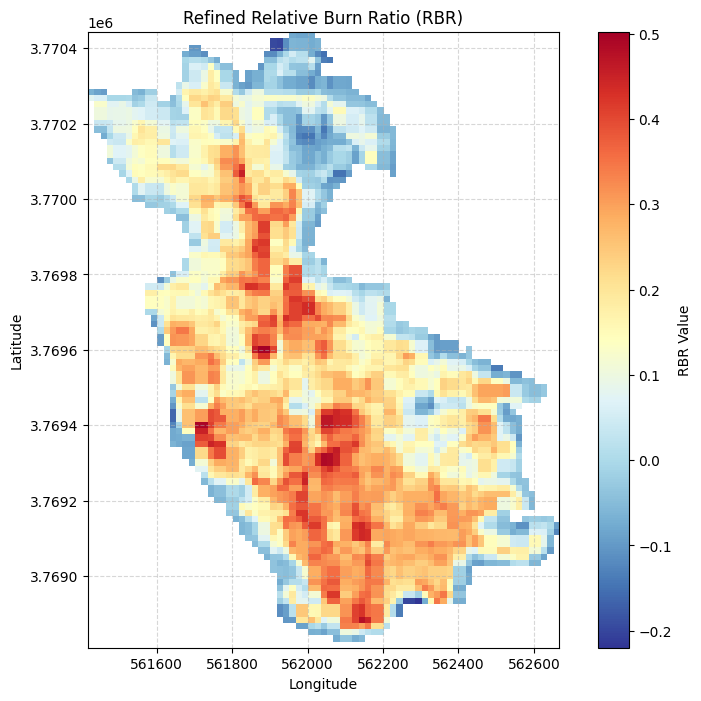

In [ ]:
#Visualize fire severity

with rasterio.open(raster_path) as src:
    rbr = src.read(1)
    rbr[rbr == src.nodata] = np.nan
    bounds = src.bounds

# Plot with correct geographic extent
plt.figure(figsize=(10, 8))
plt.imshow(
    rbr,
    cmap="RdYlBu_r",
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper"
)
plt.colorbar(label="RBR Value")
plt.title("Refined Relative Burn Ratio (RBR)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [20]:
# Polygonize the raster to extract fire boundary
with rasterio.open(raster_path) as src:
    image = src.read(1)
    mask = image != src.nodata
    results = (
        {'properties': {'rbr': v}, 'geometry': s}
        for s, v in shapes(image, mask=mask, transform=src.transform)
        if v != 0
    )
    fire_polygons = gpd.GeoDataFrame.from_features(results, crs=src.crs)

In [21]:
# Merge into one polygon for fire boundary
fire_boundary = fire_polygons.union_all()  # use union_all, not unary_union
fire_boundary = gpd.GeoDataFrame(geometry=[fire_boundary], crs=fire_polygons.crs)

In [22]:
#export fire boundary to GeoPackage
fire_boundary.to_file("generated_fire_boundary_Eureka.gpkg", layer="fire_boundary", driver="GPKG")

In [27]:
# Clip vegetation polygons to fire boundary
clipped = gpd.overlay(veg, fire_boundary, how="intersection")

#check coordinate reference system
print(clipped.crs)

#check columns
print(clipped.columns)



EPSG:26911
Index(['Poly_ID', 'MapUnit_ID', 'MapUnit_Name', 'X_Centroid', 'Y_Centroid',
       'Acres', 'Hectares', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')


In [ ]:


# Calculate area in hectares (1 ha = 10,000 m²)
clipped["area_ha"] = clipped.geometry.area / 10_000

# Group by vegetation type and calculate total hectares
summary = clipped.groupby("MapUnit_Name").agg(
    veg_ha=("area_ha", "sum")
).reset_index()

# Compute total fire area
total_fire_area = summary["veg_ha"].sum()

# Add percent of total area per vegetation type
summary["pct_of_total"] = 100 * summary["veg_ha"] / total_fire_area

# Optional: Add total row to summary
total_row = pd.DataFrame({
    "MapUnit_Name": ["Total Burned Area"],
    "veg_ha": [total_fire_area],
    "pct_of_total": [100.0]
})

# Combine with main summary
summary = pd.concat([summary, total_row], ignore_index=True)

# Export to CSV
summary.to_csv("veg_burned_summary.csv", index=False)


In [29]:
# Join summary back to polygons
clipped = clipped.merge(summary, on="MapUnit_Name", how="left")

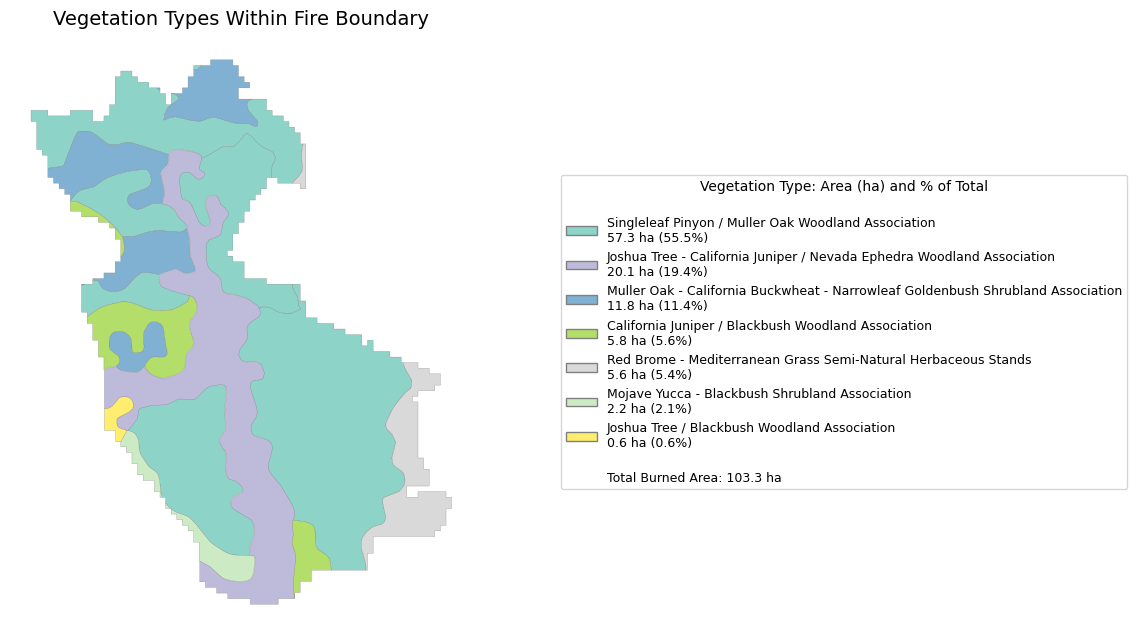

In [82]:

# Get summary of area by vegetation type
summary = clipped.groupby("MapUnit_Name").agg(
    area_ha=("area_ha", "sum")
).reset_index()
summary["pct_of_total"] = 100 * summary["area_ha"] / summary["area_ha"].sum()

# Sort by percent descending
summary = summary.sort_values(by="pct_of_total", ascending=False)
ordered_veg = summary["MapUnit_Name"].values

# Use updated colormap access (avoids deprecation warning)
base_cmap = plt.colormaps["Set3"]
color_list = base_cmap(np.linspace(0, 1, len(ordered_veg)))
colors = dict(zip(ordered_veg, color_list))

# Assign colors back to clipped
clipped["color"] = clipped["MapUnit_Name"].map(colors)

# Plot each vegetation type in order
fig, ax = plt.subplots(figsize=(10, 8))
for veg in ordered_veg:
    clipped[clipped["MapUnit_Name"] == veg].plot(
        ax=ax,
        color=colors[veg],
        edgecolor="gray",
        linewidth=0.2
    )

# Build legend entries
legend_patches = []
for veg in ordered_veg:
    row = summary[summary["MapUnit_Name"] == veg].iloc[0]
    label = f"{veg}\n{row['area_ha']:.1f} ha ({row['pct_of_total']:.1f}%)"
    patch = mpatches.Patch(facecolor=colors[veg], edgecolor='gray', label=label)
    legend_patches.append(patch)

# Add total burned area as final legend patch (invisible)
total_area = summary["area_ha"].sum()
total_label = f"\nTotal Burned Area: {total_area:.1f} ha"
total_patch = mpatches.Patch(facecolor='none', edgecolor='none', label=total_label)
legend_patches.append(total_patch)

# Add legend
ax.legend(
    handles=legend_patches,
    title="Vegetation Type: Area (ha) and % of Total\n",
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),  # Move it further right to give more space
    fontsize=9,
    handlelength=2.5,            # Length of the color patch
    borderaxespad=1.5,           # Padding around legend content
    title_fontsize=10
)


ax.set_title("Vegetation Types Within Fire Boundary", fontsize=14, loc="center")
ax.axis("off")
plt.tight_layout()
plt.show()


In [136]:
# Define the exact order you want
ordered_veg = [
    "Singleleaf Pinyon / Muller Oak Woodland Association",
    "Joshua Tree - California Juniper / Nevada Ephedra Woodland Association",
    "Muller Oak - California Buckwheat - Narrowleaf Goldenbush Shrubland Association",
    "California Juniper / Blackbush Woodland Association",
    "Red Brome - Mediterranean Grass Semi-Natural Herbaceous Stands",
    "Mojave Yucca - Blackbush Shrubland Association",
    "Joshua Tree / Blackbush Woodland Association"
]

# 1) Compute zonal stats for each clipped vegetation polygon
stats = zonal_stats(
    clipped,
    raster_path,
    stats=["min", "max", "mean", "median", "std", "count"],
    nodata=np.nan
)

# 2) Build DataFrame and attach veg labels
df = pd.DataFrame(stats)
df["MapUnit_Name"] = clipped["MapUnit_Name"].values

# 3) Aggregate per vegetation type
summary = (
    df
    .groupby("MapUnit_Name")
    .agg(
        n_pixels   = ("count",  "sum"),
        min_RBR    = ("min",    "min"),
        max_RBR    = ("max",    "max"),
        mean_RBR   = ("mean",   "mean"),
        median_RBR = ("median", "mean"),
        sd_RBR     = ("std",    "mean")
    )
    .reset_index()
)

# 4) Re‐order the rows to match your violin order
summary = (
    summary
    .set_index("MapUnit_Name")
    .loc[ordered_veg]            # reindex in desired order
    .reset_index()
)

# 5) Display the ordered summary
print("Fire Severity Summary by Vegetation Type (custom order):")
display(summary)


Fire Severity Summary by Vegetation Type (custom order):


,MapUnit_Name,n_pixels,min_RBR,max_RBR,mean_RBR,median_RBR,sd_RBR
0,Singleleaf Pinyon / Muller Oak Woodland Associ...,2074,-0.196076,0.459427,0.148718,0.146518,0.103510
1,Joshua Tree - California Juniper / Nevada Ephe...,711,-0.163371,0.491433,0.261363,0.283515,0.119096
2,Muller Oak - California Buckwheat - Narrowleaf...,423,-0.201327,0.428921,0.133075,0.123177,0.083634
3,California Juniper / Blackbush Woodland Associ...,208,-0.219864,0.502264,0.112941,0.129812,0.094788
4,Red Brome - Mediterranean Grass Semi-Natural H...,203,-0.123796,0.274335,0.031413,0.003902,0.097575
5,Mojave Yucca - Blackbush Shrubland Association,82,-0.082166,0.418134,0.091542,0.064049,0.140413
6,Joshua Tree / Blackbush Woodland Association,22,-0.126338,0.491433,0.085180,-0.037145,0.185731


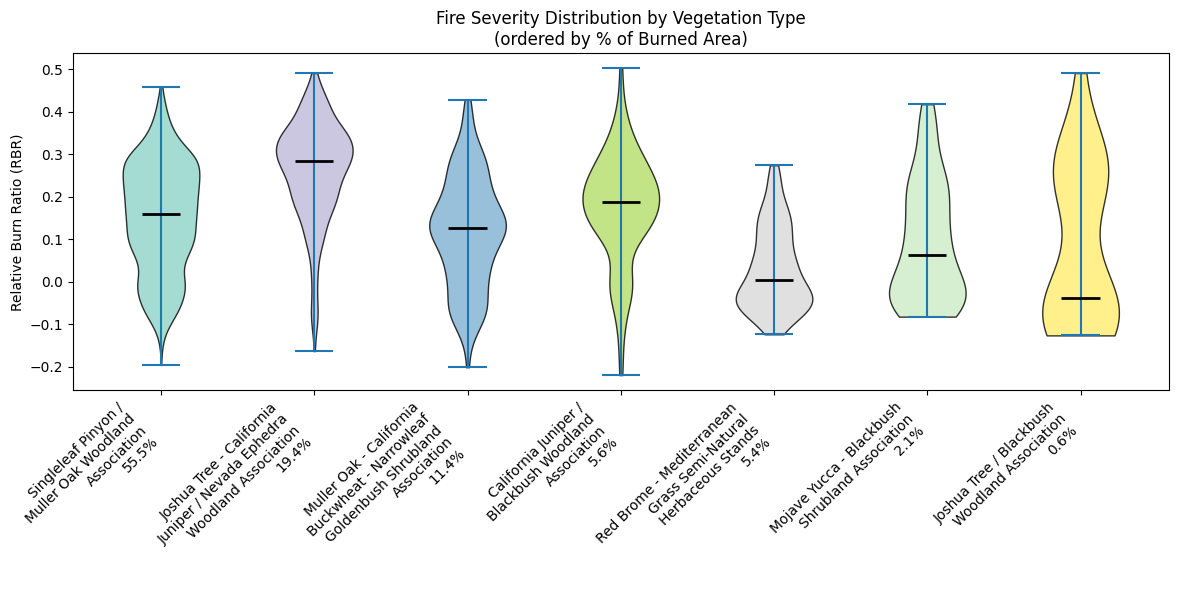

In [111]:

#Plot fire severity by vegetation type

# --- 1) Determine the order by descending percent burned ---
ordered_veg = (
    summary
    .sort_values("pct_of_total", ascending=False)
    ["MapUnit_Name"]
    .tolist()
)

# --- 2) Sample RBR under each veg type in that order ---
pixel_values = []
with rasterio.open(raster_path) as src:
    nodata = src.nodata
    for veg in ordered_veg:
        geoms = clipped[clipped["MapUnit_Name"] == veg].geometry
        data, _ = mask(src, geoms, crop=False)
        arr = data[0]
        pixel_values.append(arr[arr != nodata])

# --- 3) Prepare Set3 colors in the same order ---
cmap = plt.colormaps["Set3"]
colors_list = cmap(np.linspace(0, 1, len(ordered_veg)))

# --- 4) Build wrapped labels with percentage ---
labels = []
for veg in ordered_veg:
    pct = summary.loc[summary["MapUnit_Name"] == veg, "pct_of_total"].values[0]
    name_wrapped = textwrap.fill(veg, 25)
    labels.append(f"{name_wrapped}\n{pct:.1f}%")

# --- 5) Plot the violins in order ---
fig, ax = plt.subplots(figsize=(12, max(6, len(ordered_veg)*0.5)))
positions = np.arange(1, len(ordered_veg)+1)
parts = ax.violinplot(pixel_values, positions, showmedians=True)

for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(colors_list[i])
    body.set_edgecolor("black")
    body.set_alpha(0.8)

parts["cmedians"].set_color("black")
parts["cmedians"].set_linewidth(2)

# --- 6) Apply the new x‐axis labels ---
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha="right")

ax.set_ylabel("Relative Burn Ratio (RBR)")
ax.set_title("Fire Severity Distribution by Vegetation Type\n(ordered by % of Burned Area)")

plt.tight_layout()
plt.show()


Fire History

In [83]:
#Load the full fire history layer

fire_hist = gpd.read_file("HistFires_JOTR_MOJA/FindExistingLocationsOutput.shp")
fire_hist = fire_hist.to_crs("EPSG:26911")

In [86]:
#Check coordinate systems
print(fire_hist.crs)
print(fire_boundary.crs)


EPSG:26911
PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26911"]]


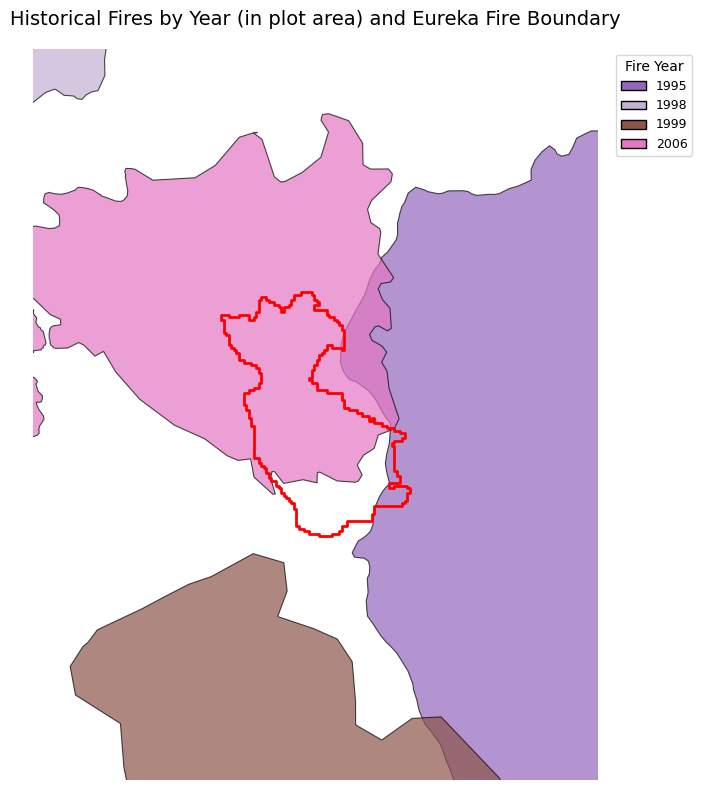

In [133]:
#Plot historical fires and Eureka fire boundary

# 1) Prepare sorted list of all years & their colors
all_years = sorted(fire_hist["YEAR_"].unique())
cmap = plt.colormaps["tab20"]
palette = cmap(np.linspace(0, 1, len(all_years)))
color_map = dict(zip(all_years, palette))

# 2) Compute 100% buffer around the current boundary
minx, miny, maxx, maxy = fire_boundary.total_bounds
dx, dy = maxx - minx, maxy - miny
buffer = 1.0
view_bounds = shapely.geometry.box(
    minx - dx*buffer, 
    miny - dy*buffer, 
    maxx + dx*buffer, 
    maxy + dy*buffer
)

# 3) Find which fires intersect that buffered box
visible = fire_hist[fire_hist.geometry.intersects(view_bounds)]
visible_years = sorted(visible["YEAR_"].unique())

# 4) Plot all historic fires (only the visible ones actually appear in the frame)
fig, ax = plt.subplots(figsize=(10, 8))
for yr in all_years:
    fire_hist[fire_hist["YEAR_"] == yr].plot(
        ax=ax,
        facecolor=color_map[yr],
        edgecolor="black",
        linewidth=0.8,
        alpha=0.7
    )

# 5) Draw the red boundary
fire_boundary.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none",
    linewidth=2
)

# 6) Zoom to the buffered view
ax.set_xlim(minx - dx*buffer, maxx + dx*buffer)
ax.set_ylim(miny - dy*buffer, maxy + dy*buffer)

# 7) Build legend only for visible years
handles = [
    mpatches.Patch(facecolor=color_map[yr], edgecolor="black", label=str(yr))
    for yr in visible_years
]
ax.legend(
    handles=handles,
    title="Fire Year",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    fontsize=9
)

ax.set_title("Historical Fires by Year (in plot area) and Eureka Fire Boundary", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [130]:
#Spatial filter: which historical fires intersect the current fire boundary?
overlapping_fires = gpd.overlay(fire_hist, fire_boundary, how='intersection')
overlapping_fires[["FIRE_NAME", "YEAR_"]].drop_duplicates()

,FIRE_NAME,YEAR_
0,WHISPERING PINES,2006
1,COVINGTON,1995


In [139]:
# Pull out the two historical fire polygons
whispering = fire_hist[fire_hist["FIRE_NAME"] == "WHISPERING PINES"]
covington  = fire_hist[fire_hist["FIRE_NAME"] == "COVINGTON"]


Burn severity by Fire history 

In [ ]:

#   union all burned polygons
burned_union = hist_clipped.geometry.union_all()

# union the full study-area boundary
boundary_union = fire_boundary.geometry.union_all()

# carve out the Unburned area
unburned_poly = boundary_union.difference(burned_union)
unburned_gdf = gpd.GeoDataFrame(
    {"geometry": [unburned_poly]},
    crs=fire_boundary.crs
)

# zonal stats on that Unburned mask
ub_stats = zonal_stats(
    unburned_gdf,
    raster_path,
    stats=["min","max","mean","std"],
    nodata=np.nan,
    geojson_out=True
)
ub_gdf = gpd.GeoDataFrame.from_features(ub_stats)
ub_gdf["FIRE_NAME"] = "Unburned"
ub_gdf["YEAR_"]     = 0   # sentinel year

#  summarize exactly like the others
unburned_summary = (
    ub_gdf
    .groupby(["YEAR_","FIRE_NAME"])
    .agg(
        min_RBR  = ("min",  "min"),
        max_RBR  = ("max",  "max"),
        mean_RBR = ("mean", "mean"),
        sd_RBR   = ("std",  "mean"),
        area_ha  = ("geometry", lambda g: g.area.sum() / 10000)
    )
    .reset_index()
)

#  stitch it onto your existing two-row summary
full_fire_history = pd.concat(
    [fire_history_summary, unburned_summary],
    ignore_index=True
)

print(" Burn Severity by Fire History")
display(full_fire_history)


 Burn Severity by Fire History


,YEAR_,FIRE_NAME,min_RBR,max_RBR,mean_RBR,sd_RBR,area_ha
0,1995,COVINGTON,-0.123796,0.261695,0.027619,0.089724,4.586149
1,2006,WHISPERING PINES,-0.201327,0.502264,0.155107,0.136093,75.543807
2,0,Unburned,-0.219864,0.474377,0.209373,0.132453,23.377412


In [ ]:
Burn severity by Vegetation:Fire history 

In [167]:

# Your desired vegetation order
ordered_veg = [
    "Singleleaf Pinyon / Muller Oak Woodland Association",
    "Joshua Tree - California Juniper / Nevada Ephedra Woodland Association",
    "Muller Oak - California Buckwheat - Narrowleaf Goldenbush Shrubland Association",
    "California Juniper / Blackbush Woodland Association",
    "Red Brome - Mediterranean Grass Semi-Natural Herbaceous Stands",
    "Mojave Yucca - Blackbush Shrubland Association",
    "Joshua Tree / Blackbush Woodland Association"
]

# If you want to control the order of FIRE_NAME too:
ordered_fire = ["COVINGTON", "WHISPERING PINES", "Previously Unburned"]

# Cast both columns to ordered categoricals
full_veg_hist["MapUnit_Name"] = pd.Categorical(
    full_veg_hist["MapUnit_Name"],
    categories=ordered_veg,
    ordered=True
)
full_veg_hist["FIRE_NAME"] = pd.Categorical(
    full_veg_hist["FIRE_NAME"],
    categories=ordered_fire,
    ordered=True
)

# Sort by veg then by fire
full_veg_hist = (
    full_veg_hist
    .sort_values(["MapUnit_Name", "FIRE_NAME"])
    .reset_index(drop=True)
)

print("🔥 Ordered Burn Severity by Vegetation × Fire History")
display(full_veg_hist)


🔥 Ordered Burn Severity by Vegetation × Fire History


,MapUnit_Name,YEAR_,FIRE_NAME,min_RBR,max_RBR,mean_RBR,sd_RBR,area_ha
0,Singleleaf Pinyon / Muller Oak Woodland Associ...,1995,COVINGTON,0.036931,0.151126,0.083066,0.048671,0.073576
1,Singleleaf Pinyon / Muller Oak Woodland Associ...,2006,WHISPERING PINES,-0.196076,0.459427,0.146402,0.099279,43.929009
2,Singleleaf Pinyon / Muller Oak Woodland Associ...,0,Previously Unburned,-0.080014,0.422675,0.218790,0.114732,13.312362
3,Joshua Tree - California Juniper / Nevada Ephe...,2006,WHISPERING PINES,-0.163371,0.491433,0.262901,0.108962,14.166624
4,Joshua Tree - California Juniper / Nevada Ephe...,0,Previously Unburned,-0.113773,0.474377,0.257718,0.140148,5.896823
5,Muller Oak - California Buckwheat - Narrowleaf...,2006,WHISPERING PINES,-0.201327,0.428921,0.133075,0.083634,11.759396
6,California Juniper / Blackbush Woodland Associ...,2006,WHISPERING PINES,-0.108372,0.502264,0.093370,0.070862,4.410993
7,California Juniper / Blackbush Woodland Associ...,0,Previously Unburned,-0.219864,0.304877,0.152083,0.142639,1.380970
8,Red Brome - Mediterranean Grass Semi-Natural H...,1995,COVINGTON,-0.123796,0.261695,0.026232,0.090076,4.512573
9,Red Brome - Mediterranean Grass Semi-Natural H...,2006,WHISPERING PINES,-0.104842,-0.054172,-0.073517,0.018151,0.255332


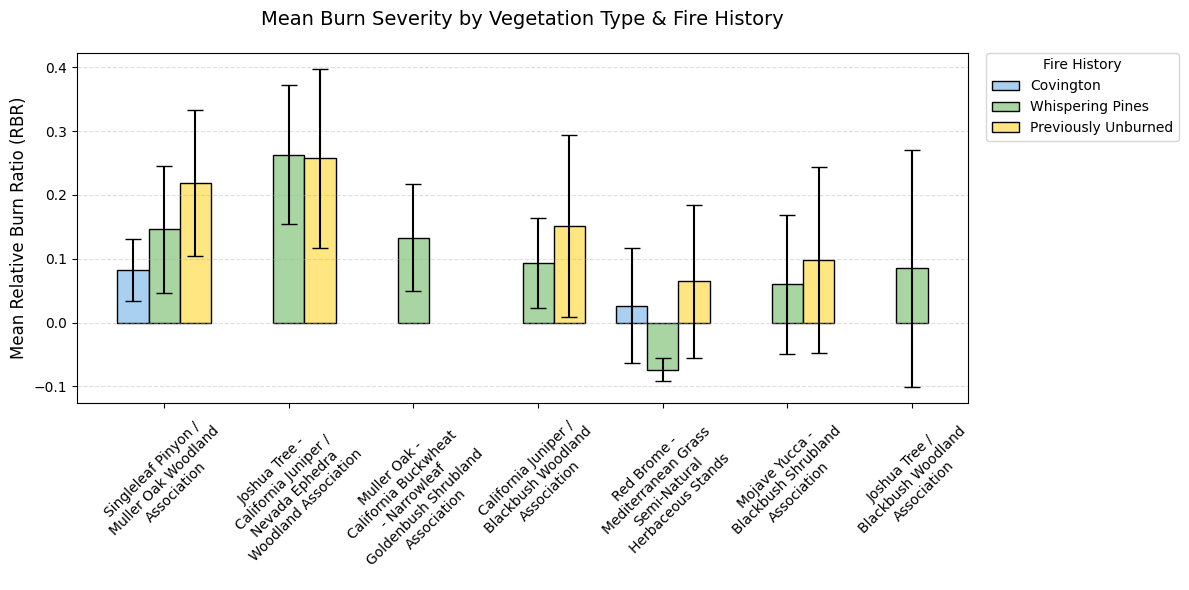

In [171]:


# Your desired order:
ordered_veg = [
    "Singleleaf Pinyon / Muller Oak Woodland Association",
    "Joshua Tree - California Juniper / Nevada Ephedra Woodland Association",
    "Muller Oak - California Buckwheat - Narrowleaf Goldenbush Shrubland Association",
    "California Juniper / Blackbush Woodland Association",
    "Red Brome - Mediterranean Grass Semi-Natural Herbaceous Stands",
    "Mojave Yucca - Blackbush Shrubland Association",
    "Joshua Tree / Blackbush Woodland Association"
]

# — Pivot & rename Unburned → Previously Unburned —
mean_piv = full_veg_hist.pivot(
    index="MapUnit_Name", columns="FIRE_NAME", values="mean_RBR"
).rename(columns={"Unburned": "Previously Unburned"})
std_piv = full_veg_hist.pivot(
    index="MapUnit_Name", columns="FIRE_NAME", values="sd_RBR"
).rename(columns={"Unburned": "Previously Unburned"})

# Enforce your category order
cats     = ["COVINGTON", "WHISPERING PINES", "Previously Unburned"]
mean_piv = mean_piv[cats]
std_piv  = std_piv[cats]

# Reindex to your custom vegetation order
mean_piv = mean_piv.reindex(ordered_veg)
std_piv  = std_piv.reindex(ordered_veg)

x         = np.arange(len(ordered_veg))
width     = 0.25
colors    = ["#A9CFF1", "#A8D5A2", "#FFE680"]  # blue, green, amber

fig, ax = plt.subplots(figsize=(12,6))

for i, cat in enumerate(cats):
    ax.bar(
        x + (i - 1)*width,
        mean_piv[cat],
        width,
        yerr=std_piv[cat],
        capsize=6,
        linewidth=1,
        edgecolor="k",
        color=colors[i],
        label=cat.title()
    )

# Wrap & center the labels
wrapped = [textwrap.fill(lbl, 20) for lbl in ordered_veg]
ax.set_xticks(x)
ax.set_xticklabels(wrapped, rotation=45, ha="center", fontsize=10)

# Styling
ax.set_ylabel("Mean Relative Burn Ratio (RBR)", fontsize=12)
ax.set_title("Mean Burn Severity by Vegetation Type & Fire History", pad=20, fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.4)

# Legend outside
ax.legend(
    title="Fire History",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()
